# Determining the Confocal Volume
## Introduction
Fluorescence Correlation Spectroscopy (FCS) is a powerful technique used to measure the diffusion coefficients of biomolecules at pico- to nanomolar concentrations, with extensive applications in biology and chemistry. Achieving accurate quantitative results with this method depends critically on knowing the size and shape of the confocal volume, which must be determined experimentally. The geometry of the confocal volume governs how fluorophores enter and exit the detection region, thereby shaping the correlation function.

The method used here to determine the effective confocal volume ($V_{eff}$) involves analyzing a sample with a known diffusion coefficient. This approach has a significant advantage: the sample concentration does not need to be precisely measured, reducing potential sources of error. However, its limitation is that accurate diffusion coefficients are only well-established for a limited number of dyes.

There are two other common methods for determining $V_{eff}$:  
1) Using a sample with a known concentration – This requires highly accurate concentration measurements. Uncertainties in sample absorption, losses during dilution steps, or adsorption to surfaces can introduce errors.  
2) Raster scanning of immobilized sub-resolution fluorescent beads – This method requires a highly precise scanning system to map the confocal volume.  

If performed correctly, all three approaches yield comparable accuracy and precision, with typical errors of approximately ±10%.  

In this notebook, we will first focus on loading and fitting FCS data of Fluorescein in water before deriving the confocal volume from the fitting results in conjunction with a known diffusion coefficient. For further details on diffusion coefficients, see _FCS_Calibration_Diffusion_Coefficients.ipynb_.

#### Notes on Data Collection  
- Laser power should be kept low to avoid photobleaching. The optimal power depends on the fluorophore, but an average power of ~20 μW is generally suitable. It is advisable to measure a saturation curve for your fluorophore to determine safe laser power levels that do not induce bleaching.  
- To accurately determine $V_{eff}$, it is recommended to perform these experiments in triplicate and across a range of concentrations (~ 0.1 – 5 nM), then average the resulting volume.

## Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Loading the Data
First, we define a function for loading our data. This function is tailored to import data exported in ASCII format from Picoquants SymPhoTime64 software, although it can be readily adapted to load any pre-computed FCS curve. The data used for example here is Fluorescein in water measured for 60 s.

In [37]:
def load_fcs_data(filename):
    data = np.genfromtxt(filename, skip_header=2, delimiter='\t', invalid_raise=False)
    data = data[~np.isnan(data).any(axis=1)]  # Remove rows with NaNs
    corr_time_measured = data[:, 0]
    g_measured = data[:, 1] * 10**-3 # If you're loading your own data, please check that the units are correct by checking the file header!
    g_error = data[:, 2] * 10**-3 
    return corr_time_measured, g_measured, g_error

filename = r'.\data\fluorescein_fcs_curve.dat'
corr_time_measured, g_measured, g_error = load_fcs_data(filename)

Next, as an initial validation, we can visualize the data to ensure that it loaded as expected.

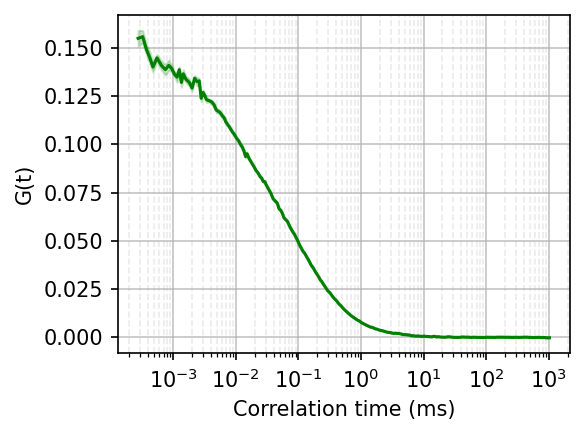

In [7]:
def simple_plot_fcs_data(corr_time_measured, g_measured, g_error):
    plt.figure(figsize=(4, 3), dpi=150)
    plt.plot(corr_time_measured, g_measured, color='g', zorder=3)
    upper_confidence = g_measured + g_error
    lower_confidence = g_measured - g_error
    plt.fill_between(corr_time_measured, lower_confidence, upper_confidence, color='g', alpha=0.2, zorder=4)
    plt.xscale('log')
    plt.xlabel('Correlation time (ms)')
    plt.ylabel('G(t)')
    plt.grid(True, which='major', linestyle='-', alpha=0.75)
    plt.grid(True, which='minor', linestyle='--', alpha=0.25)
    plt.tight_layout()
    plt.show()

simple_plot_fcs_data(corr_time_measured, g_measured, g_error)

## Fitting the Data
Now, let's fit the data using the following function, which describes a single diffusing species through a three-dimensional Gaussian-shaped volume:  
$$
G(t) = \rho \cdot \left( 1+\frac{t}{\tau_{Diff}}\right)^{-1} \cdot \left( \left( 1 + \frac{t}{\tau_{Diff} \cdot \kappa^{2}} \right)^{0.5} \right)^{-1}
$$
where:
- $G(t)$ = Autocorrelation function at time $t$ 
- $\rho$ =  Contribution of the diffusing species
- $\tau_{Diff}$ = Diffusion time of the species
- $\kappa$ = Aspect ratio (length to diameter) of the confocal focal volume

This function can be implemented in Python as follows:

In [9]:
def fcs_correlation_function(t, rho, tau_diff, k):
    G = rho * (1 + (t / tau_diff))**-1 * ((1 + t / (tau_diff * k**2))**0.5)**-1
    return G

and fit using scipy curve_fit using: 

In [11]:
def fcs_fit_function(t, *params):
    rho, tau_diff, k = params
    return fcs_correlation_function(t, rho, tau_diff, k)

def fit_fcs_data(corr_time_measured, g_measured, g_error):
    # Initial parameter guesses
    # [rho, tau_diff, k]
    p0 = [1.0, 50e-6, 4]
    
    # Bounds for parameters to help convergence
    lower_bounds = [0, 0, 1]
    upper_bounds = [1e6, 1e+3, 20]
    
    # Perform curve fitting
    popt, pcov = curve_fit(
        fcs_fit_function, 
        corr_time_measured, 
        g_measured, 
        p0=p0, 
        sigma=g_error, 
        absolute_sigma=True,
        bounds=(lower_bounds, upper_bounds)
    )
    
    # Calculate fitted values
    g_fitted = fcs_fit_function(corr_time_measured, *popt)
    
    return popt, pcov, g_fitted

# Perform curve fitting
popt, pcov, g_fitted = fit_fcs_data(corr_time_measured, g_measured, g_error)

and then plot the results

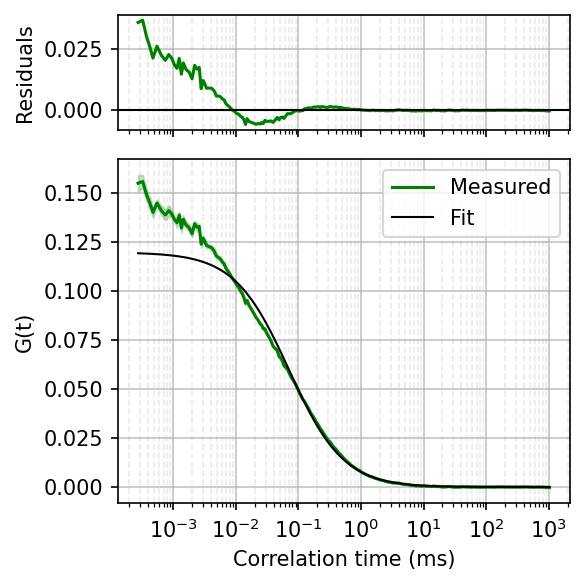

In [13]:
def plot_fcs_data(corr_time_measured, g_measured, g_error, corr_time_fitted, g_fitted, residuals, fit_params=None):
    fig, axes = plt.subplots(2, 1, figsize=(4, 4), dpi=150, sharex=True, gridspec_kw={'height_ratios': [1, 3]})

    axes[0].plot(corr_time_measured, residuals, color='g', zorder=5)
    axes[0].axhline(0, color='k', linestyle='-', linewidth=1, zorder=10)
    axes[0].set_ylabel('Residuals')
    axes[0].grid(True, which='major', linestyle='-', alpha=0.75)
    axes[0].grid(True, which='minor', linestyle='--', alpha=0.25)

    axes[1].plot(corr_time_measured, g_measured, color='g', label='Measured', zorder=3)
    
    upper_confidence = g_measured + g_error
    lower_confidence = g_measured - g_error
    axes[1].fill_between(corr_time_measured, lower_confidence, upper_confidence, color='g', alpha=0.2, zorder=4)
    
    axes[1].plot(corr_time_measured, g_fitted, 'k-', label='Fit', linewidth=1, zorder=5)
    
    # Log scale for x-axis
    axes[1].set_xscale('log')
    
    axes[1].set_xlabel('Correlation time (ms)')
    axes[1].set_ylabel('G(t)')
    axes[1].legend()
    axes[1].grid(True, which='major', linestyle='-', alpha=0.75)
    axes[1].grid(True, which='minor', linestyle='--', alpha=0.25)
    
    plt.tight_layout()
    
    plt.show()

# Plot results
plot_fcs_data(corr_time_measured, g_measured, g_error, corr_time_measured, g_fitted, 
              g_measured - g_fitted, fit_params=popt)

As you can see, the model does not provide a good fit to the data, with the poorest agreement occurring at shorter correlation times. Beyond translational diffusion, one of the most common processes affecting the autocorrelation function is singlet-triplet kinetics. Triplet states are non-fluorescent (often referred to as "dark" states) and have relatively long lifetimes, typically ranging from microseconds to milliseconds. Given this, we can extend our model by incorporating a triplet state and assess whether this improves the fit to the data as so: 

$$
G(t) = \left( 1+T \left( \exp \left( -\frac{t}{\tau_{Trip}} \right) -1 \right) \right) \cdot \rho \cdot \left( 1+\frac{t}{\tau_{Diff}}\right)^{-1} \cdot \left( \left( 1 + \frac{t}{\tau_{Diff} \cdot \kappa^{2}} \right)^{0.5} \right)^{-1}
$$

where: 
- $T$ = Fraction of molecules in the triplet state
- $\tau_{Trip}$ = Lifetime of the triplet state.

and fit the data again using the new model:

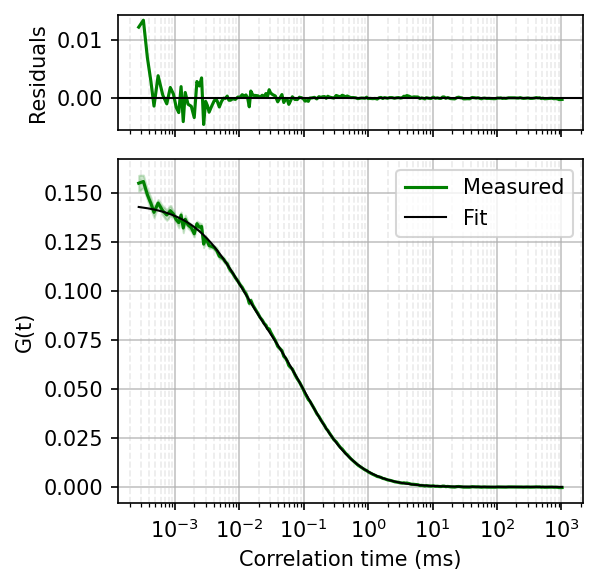

In [15]:
def fcs_correlation_function(t, rho, tau_diff, T, tau_trip, k):
    triplet_term = 1 + T * (np.exp(- (t / tau_trip)) - 1)
    diffusion_term = rho * (1 + (t / tau_diff))**-1 * ((1 + t / (tau_diff * k**2))**0.5)**-1
    G = triplet_term * diffusion_term
    return G

def fcs_fit_function(t, *params):
    rho, tau_diff, T, tau_trip, k = params
    return fcs_correlation_function(t, rho, tau_diff, T, tau_trip, k)

def fit_fcs_data(corr_time_measured, g_measured, g_error):
    # Initial parameter guesses
    # [rho, tau_diff, T, tau_trip, k]
    p0 = [1.0, 50e-6, 0.1, 5e-3, 4]
    
    # Bounds for parameters to help convergence
    lower_bounds = [0, 0, 0, 1e-4, 1]
    upper_bounds = [1e6, 1e+3, 1, 1e-2, 20]
    
    # Perform curve fitting
    popt, pcov = curve_fit(
        fcs_fit_function, 
        corr_time_measured, 
        g_measured, 
        p0=p0, 
        sigma=g_error, 
        absolute_sigma=True,
        bounds=(lower_bounds, upper_bounds)
    )
    
    # Calculate fitted values
    g_fitted = fcs_fit_function(corr_time_measured, *popt)
    
    return popt, pcov, g_fitted

# Perform curve fitting
popt, pcov, g_fitted = fit_fcs_data(corr_time_measured, g_measured, g_error)
plot_fcs_data(corr_time_measured, g_measured, g_error, corr_time_measured, g_fitted, g_measured - g_fitted, fit_params=popt)

As we can see, this model provides a significantly improved fit to the data. Now, let's print the fitted parameters:

In [17]:
def print_fit_parameters(popt, pcov):
    """
    Print the optimized fit parameters with their estimated uncertainties.
    
    Parameters:
    -----------
    popt : array
        Optimized parameters from the fit.
    pcov : array
        Covariance matrix of the parameters.
    """
    param_names = ["rho", "tau_diff", "T", "tau_trip", "k"]
    uncertainties = np.sqrt(np.diag(pcov))  # Extract standard deviations from covariance matrix
    
    print("Fitted Parameters:")
    for name, value, error in zip(param_names, popt, uncertainties):
        print(f"{name}: {value:.3g} ± {error:.3g}")

print_fit_parameters(popt, pcov)

Fitted Parameters:
rho: 0.145 ± 0.000551
tau_diff: 0.0959 ± 0.000881
T: 0.291 ± 0.00326
tau_trip: 0.00804 ± 0.000235
k: 5.78 ± 0.172


## Determining the Effective Confocal Volume

We can calculate the effective confocal volume using the following equation: 

$$
V_{eff} = \kappa \cdot (4 \cdot D \cdot \tau_{Diff} \cdot \pi)^{\frac{3}{2}}
$$

We calculated both $\kappa$ and $\tau_{Diff}$ are derived from fitting of FCS curves. Note that $V_{eff}$ is larger than the confocal volume typically referred to in the literature by a factor of $2^{(\frac{3}{2})}$.

We can define a python function for this equation and use it to calculate our $V_{eff}$

In [19]:
def veff_from_D_k_tau_diff(k, D, tau_diff):
    veff = k * (4 * D * tau_diff * np.pi)**(3/2)
    return veff

tau_diff = popt[1]             # Second parameter from our fit is tau_diff (in ms)
tau_diff_s = tau_diff/1000     # Convert from ms to s
k = popt[4]                    # Fifth parameter is k
D = 3.8183e-10

veff = veff_from_D_k_tau_diff(k, D, tau_diff_s)

Which gives us an answer of $V_{eff}$ =

In [21]:
print(veff)

1.8040893373058184e-18


Which we can then convert to the more commonly used unit of femtoliters (fl)

In [23]:
print(f'{veff*1e18:.3}', 'fl')

1.8 fl


# Conclusion
In this notebook, we have loaded and fitted FCS data for Fluorescein in water, extracting key parameters from the fits. Using a known diffusion coefficient, we then determined $V_{eff}$, providing a crucial calibration step for quantitative FCS measurements.  